In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
directory = "/content/drive/Othercomputers/Iliya-PC/GrayPhoto"
input_dir = os.path.join(directory, "train")
input_img_paths = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in input_img_paths])

print("Number of samples:", len(input_img_paths))

Number of samples: 185


(3000, 4000, 3)


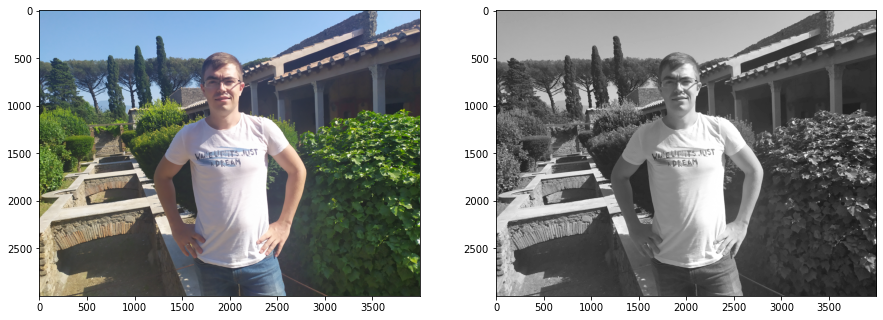

In [5]:
idx = 120

img = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
grey = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2GRAY)

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(grey, cmap='gray')

print(img.shape)

In [6]:
# Data generator
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

class PhotoGenerator(keras.utils.Sequence):    
    def __init__(self, batch_size, img_size, img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to **batch** index."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, grayscale=True, target_size=self.img_size, color_mode="grayscale")
            x[j] = img
            img = load_img(path, target_size=self.img_size)
            y[j] = img
            
        return x/255, y/255
    
    def on_epoch_end(self):
        self.input_img_paths, self.target_img_paths = shuffle(self.input_img_paths, self.target_img_paths)

In [10]:
img_size = (320, 320)
batch_size = 128

In [ ]:
#Using U-Net architecture 

def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add output layer with sigmoid activation function (result between 0 and 1)
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()